In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

# Import and Clean Data

In [2]:
# Load the data
training_data = pd.read_csv('Data/training.csv')
training_data.drop(columns=['Unnamed: 0', 'pad_id'], inplace=True)
training_data.drop_duplicates(inplace=True)
training_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert any "Undefined" or "Unknown" values to NaN
training_data.replace('Undefined', np.nan, inplace=True)
training_data.replace('Unknown', np.nan, inplace=True)

# Before imputing, keep track of rows with missing values for 'OilPeakRate' to remove them later
rows_with_missing_values = training_data[training_data['OilPeakRate'].isnull()].index.to_list()

In [249]:
# Print number of missing values per column
print(training_data.isnull().sum())

surface_x                           0
surface_y                           0
bh_x                             2079
bh_y                             2079
standardized_operator_name          0
gross_perforated_length          7548
number_of_stages                26930
total_proppant                  10602
total_fluid                     10606
true_vertical_depth              1488
ffs_frac_type                   16112
proppant_intensity              10711
frac_fluid_intensity            10736
average_stage_length            26958
average_proppant_per_stage      26993
average_frac_fluid_per_stage    26995
proppant_to_frac_fluid_ratio    11026
frac_fluid_to_proppant_ratio    11027
bin_lateral_length               7548
relative_well_position           9813
batch_frac_classification       14971
well_family_relationship         9813
frac_type                           0
frac_seasoning                  14914
horizontal_midpoint_x             994
horizontal_midpoint_y             994
horizontal_t

# Data Preprocessing

In [3]:
# Create a 'well_length' column
# The formula for well length is sqrt(|surface_x - bh_x|^2 + |surface_y - bh_y|^2 + true_vertical_depth^2)
training_data['well_length'] = np.sqrt((training_data['surface_x'] - training_data['bh_x'])**2 + (training_data['surface_y'] - training_data['bh_y'])**2 + training_data['true_vertical_depth']**2)

# Drop columns that are now redundant
# training_data.drop(columns=['surface_x', 'surface_y', 'bh_x', 'bh_y', 'true_vertical_depth'], inplace=True)

In [4]:
# Imputing numeric features
numeric_columns = training_data.select_dtypes(include=['float64', 'int64']).columns
numeric_imputer = SimpleImputer(strategy='median')
training_data[numeric_columns] = numeric_imputer.fit_transform(training_data[numeric_columns])

# Imputing categorical features
categorical_columns = training_data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
training_data[categorical_columns] = categorical_imputer.fit_transform(training_data[categorical_columns])

# Encode categorical variables
training_data = pd.get_dummies(training_data)
print(training_data.shape)

(29682, 42)


In [4]:
# Encode categorical variables
training_data = pd.get_dummies(training_data)
print(training_data.shape)

# Impute missing values with KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Keep column names
training_data_columns = training_data.columns
training_data[training_data_columns] = imputer.fit_transform(training_data)

(29682, 42)


In [252]:
# Drop rows with missing values for 'OilPeakRate'
training_data.drop(rows_with_missing_values, inplace=True)

In [108]:
# Encode categorical variables
training_data = pd.get_dummies(training_data)
print(training_data.shape)

(19306, 44)


# Visualize Data

In [189]:
# Add a log-transformed version of 'OilPeakRate' to the data
training_data['log_OilPeakRate'] = np.log(training_data['OilPeakRate'])

<Axes: xlabel='OilPeakRate', ylabel='Count'>

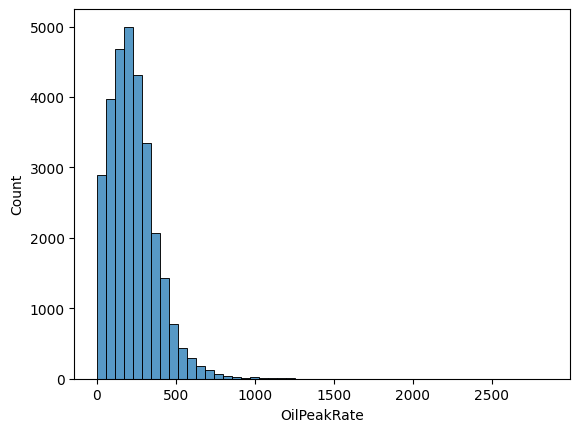

In [13]:
# Plot a histogram of 'OilPeakRate'
sns.histplot(training_data['OilPeakRate'], bins=50)

/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


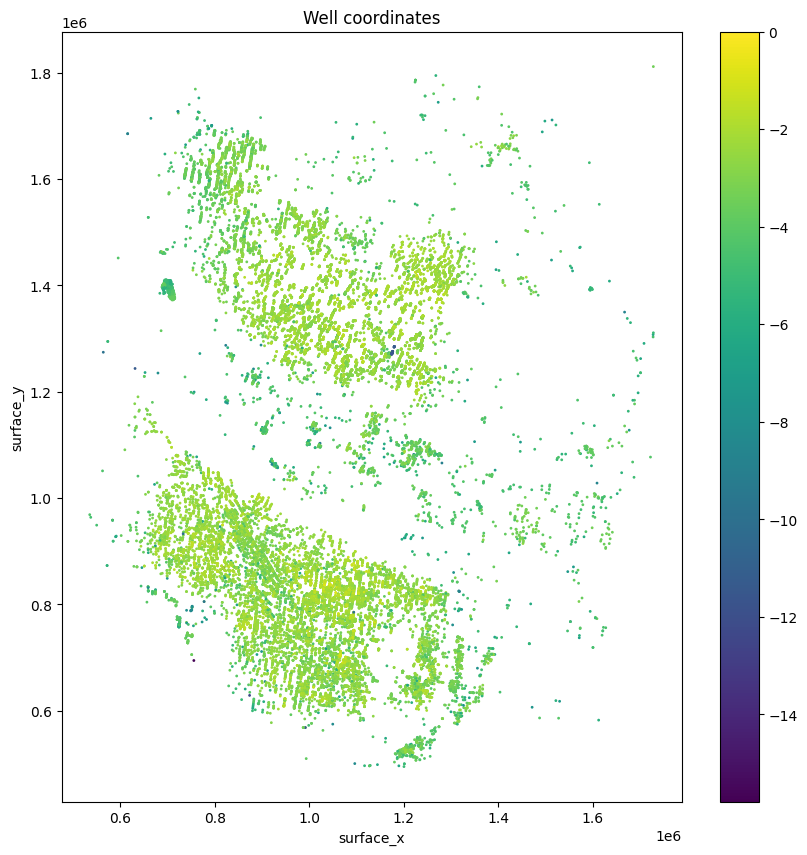

In [14]:
# Plot the well coordinates "surface_x" and "surface_y"
# Normalize the "OilPeakRate" values to be between 0 and 1 and make them a new column
training_data['NormOilPeakRate'] = (training_data['OilPeakRate'] - training_data['OilPeakRate'].min()) / (training_data['OilPeakRate'].max() - training_data['OilPeakRate'].min())
training_data['NormOilPeakRate'] = np.log(training_data['NormOilPeakRate'])

plt.figure(figsize=(10, 10))
plt.scatter(training_data['surface_x'], training_data['surface_y'], c=training_data['NormOilPeakRate'], s=1)
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()

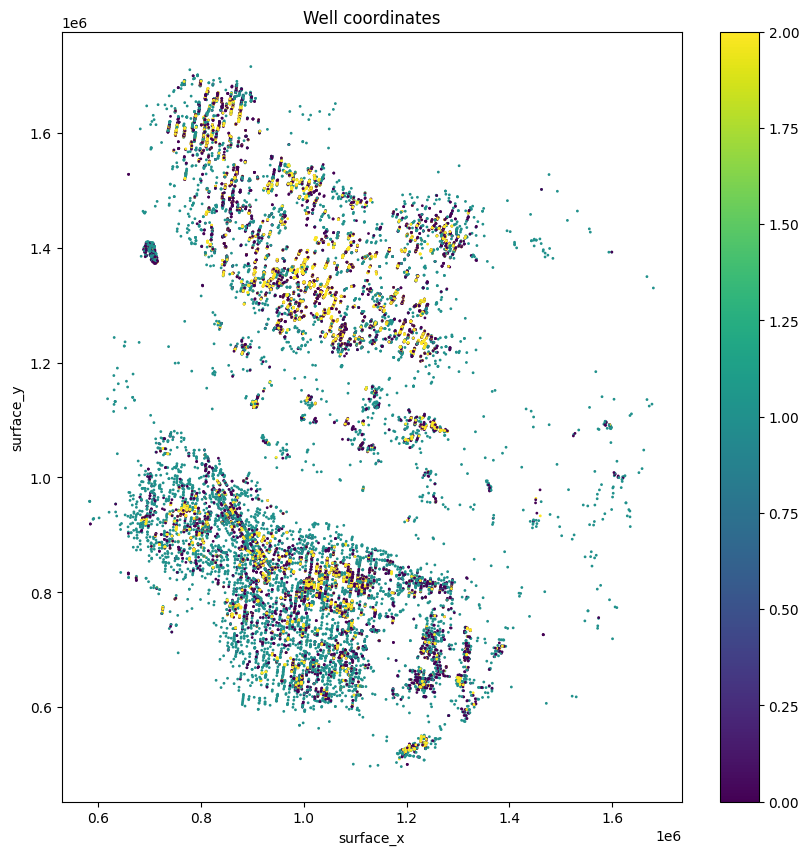

In [202]:
# Plot the well coordinates "surface_x" and "surface_y"
# Color points by the "relative_well_position" feature in log scale
# First, remove the rows with missing values for 'relative_well_position'
training_data.dropna(subset=['relative_well_position'], inplace=True)
# Map the 'relative_well_position' categorical feature to numeric values
training_data['relative_well_position'] = training_data['relative_well_position'].map({'Outer Well': 0, 'Standalone Well': 1, 'Inner Well': 2})
plt.figure(figsize=(10, 10))
plt.scatter(training_data['surface_x'], training_data['surface_y'], c=training_data['relative_well_position'], s=1)
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()

# Test Model Performance

In [5]:
RANDOM_STATE = 42

# Split the data into training and test sets
X = training_data.drop('OilPeakRate', axis=1)
y = training_data['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [6]:
# Instantiate the DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 113.13
Training set RMSE: 112.72


In [262]:
# Instantiate the RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 99.33
Training set RMSE: 38.47


In [258]:
# Instantiate the HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 96.79
Training set RMSE: 74.93


In [178]:
# Instantiate the AdaBoostRegressor
model = AdaBoostRegressor(n_estimators=15, estimator=DecisionTreeRegressor(max_depth=6), random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 117.00
Training set RMSE: 107.59


In [237]:
# Wrap the HistGradientBoostingRegressor in an AdaBoostRegressor
model = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(max_iter=1000),
                          n_estimators=10, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 98.19
Training set RMSE: 30.81


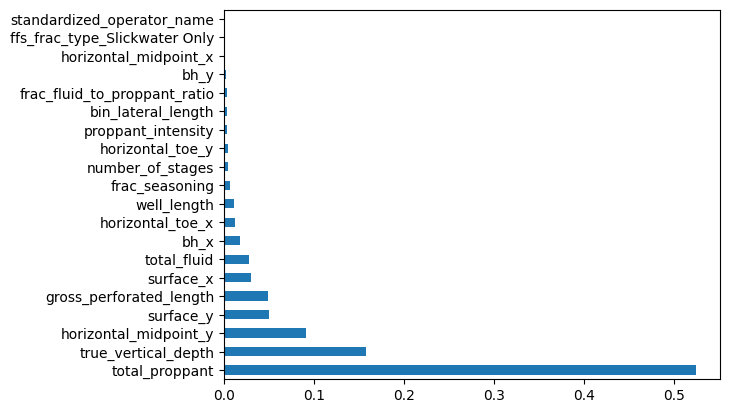

In [7]:
# Show feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.show()

In [216]:
# Instantiate the MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(500,2), max_iter=10000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 146.86
Training set RMSE: 148.65


In [17]:
# Instantiate the SVR for just surface_x and surface_y
X_s = X[['surface_x', 'surface_y']]
y_s = y

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=RANDOM_STATE)

In [18]:
# Instantiate the KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_s, y_train_s)

# Predict the test set labels
y_pred = model.predict(X_test_s)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train_s)
rmse_train = np.sqrt(mean_squared_error(y_train_s, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 99.08
Training set RMSE: 92.20


/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


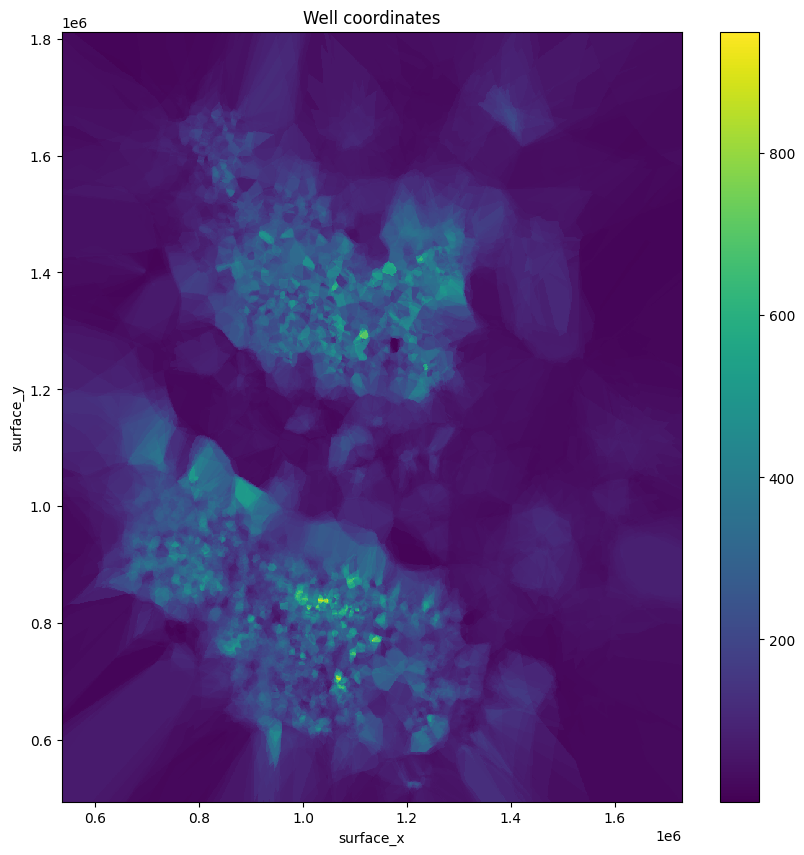

In [19]:
# Plot the mesh of the predicted values
# Create a mesh of values to plot
xx = np.linspace(X_s['surface_x'].min(), X_s['surface_x'].max(), 1000)
yy = np.linspace(X_s['surface_y'].min(), X_s['surface_y'].max(), 1000)
xx, yy = np.meshgrid(xx, yy)
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the values of the mesh
y_pred = model.predict(X_grid)

# Plot the predicted values
plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, y_pred.reshape(xx.shape))
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()